In [3]:
import os
from matplotlib import pyplot as plot
from matplotlib import ticker as ticker
import numpy as np

stats = ("Length", "Visited states", "Processed states", "Depth", "Time")
strategies = ("bfs", "dfs", "astr")
lrudVariants = ("RDUL", "RDLU", "DRUL", "DRLU", "LUDR", "LURD", "ULDR", "ULRD")
astrVariants = ("hamm", "manh")
maxTestedDepth = 7

print("Done: Initialization")

Done: Initialization


In [1]:
def packFilename(filename, strategy, variant, type):
	name, extension = os.path.splitext(filename)
	return "{}_{}_{}_{}{}".format(name, strategy, variant, type, extension)

def solvePuzzles(puzzlesDirectory, solutionsDirectory, statsDirectory):
	variants = []
	for filename in os.listdir(puzzlesDirectory):
		for strategy in strategies:
			if strategy == "astr":
				variants = astrVariants
			else:
				variants = lrudVariants
			for variant in variants:
				os.system("python main.py {} {} {} {} {}".format
				(
					strategy,
					variant,
					os.path.join(puzzlesDirectory, filename),
					os.path.join( solutionsDirectory, packFilename(filename, strategy, variant, "sol" ) ),
					os.path.join( statsDirectory, packFilename(filename, strategy, variant, "stats") )
				))

#solvePuzzles("wikamp/puzzles", "wikamp/solutions", "wikamp/stats")

print("Done: Solving Puzzles")

Done: Solving Puzzles


In [4]:
def dictUpdate(dict, argument):
	dict.update(argument)
	return dict

def unpackFilename(filename):
	name, extension = os.path.splitext(filename)
	puzzleSize, iterations, puzzleId, strategy, variant, type = name.split("_") 
	return iterations, strategy, variant, type

def loadStats(statsDirectory, iterations):
	bfsStats = dictUpdate({}, {stat:dictUpdate({}, {variant:dictUpdate({}, {it:[] for it in range(1, iterations + 1)}) for variant in lrudVariants} ) for stat in stats})
	dfsStats = dictUpdate({}, {stat:dictUpdate({}, {variant:dictUpdate({}, {it:[] for it in range(1, iterations + 1)}) for variant in lrudVariants} ) for stat in stats})
	astrStats = dictUpdate({}, {stat:dictUpdate({}, {variant:dictUpdate({}, {it:[] for it in range(1, iterations + 1)}) for variant in astrVariants} ) for stat in stats})
	for filename in os.listdir(statsDirectory):
		iterations, strategy, variant, type = unpackFilename(filename)
		iterations = int(iterations)
		with open(os.path.join(statsDirectory, filename), 'r') as f:
			for stat in stats:
				value = f.readline()
				if stat != "Time":
					value = int(value)
				else:
					value = float(value)
				if strategy == "bfs":
					bfsStats[stat][variant][iterations].append(value)
				elif strategy == "dfs":
					dfsStats[stat][variant][iterations].append(value)
				else:
					astrStats[stat][variant][iterations].append(value)
	return bfsStats, dfsStats, astrStats

bfsStats, dfsStats, astrStats = loadStats("wikamp/stats", maxTestedDepth)

print("Done: Loading Stats")

Done: Loading Stats


In [6]:
def mean(x):
	length = len(x)
	if length != 0:
		return sum(x) / length
	else:
		return 0

def calculateMeans(stats):
	for stat in stats.values():
		for variant in stat.values():
			for key, iter in variant.items():
				variant[key] = mean(iter)

def combineGlobalMeansStats(bfsStats, dfsStats, astrStats, iterations):
	globalStats = dictUpdate({}, {stat:dictUpdate({}, {strategy:dictUpdate({}, {it:0 for it in range(1, iterations + 1)}) for strategy in strategies} ) for stat in stats})
	for statKey, statVal in globalStats.items():
		for strategyKey, strategyVal in statVal.items():
			for iterKey, iterVal in strategyVal.items():
				if strategyKey == "bfs":
					strategyVal[iterKey] = mean([bfsStats[statKey][variant][iterKey] for variant in lrudVariants])
				elif strategyKey == "dfs":
					strategyVal[iterKey] = mean([dfsStats[statKey][variant][iterKey] for variant in lrudVariants])
				elif strategyKey == "astr":
					strategyVal[iterKey] = mean([astrStats[statKey][variant][iterKey] for variant in astrVariants])
	return globalStats

calculateMeans(bfsStats)
calculateMeans(dfsStats)
calculateMeans(astrStats)
globalStats = combineGlobalMeansStats(bfsStats, dfsStats, astrStats, maxTestedDepth)

print("Done: Calculating all means")

Done: Calculating all means


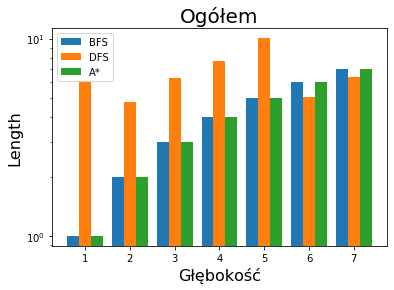

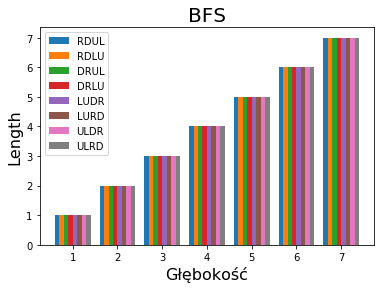

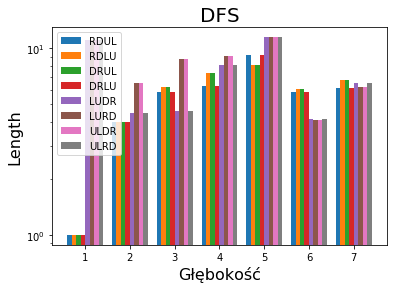

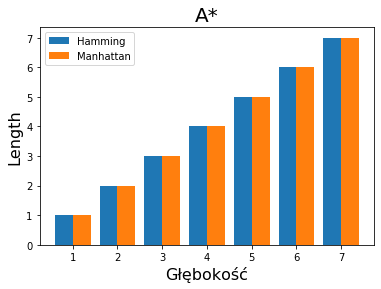

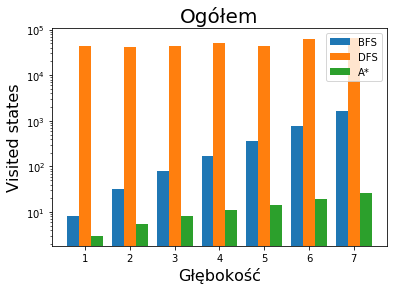

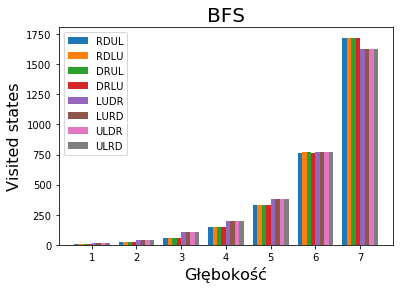

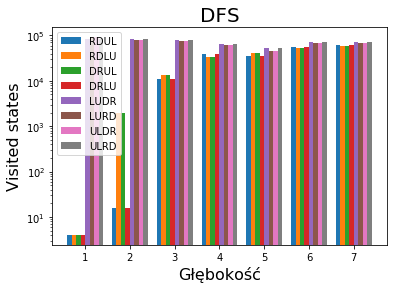

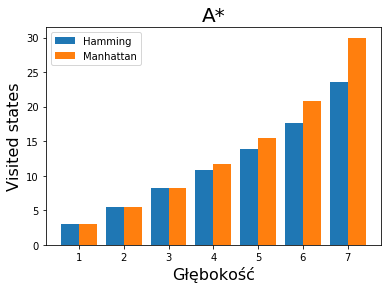

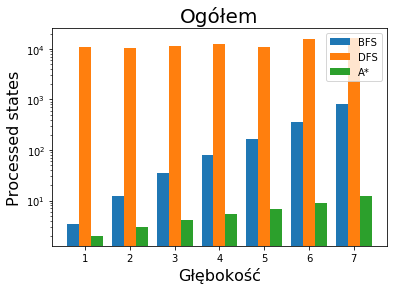

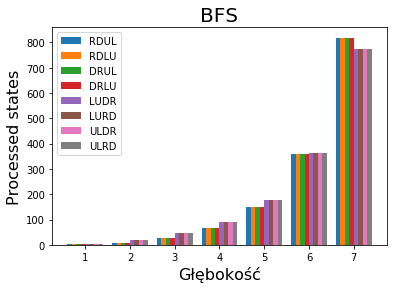

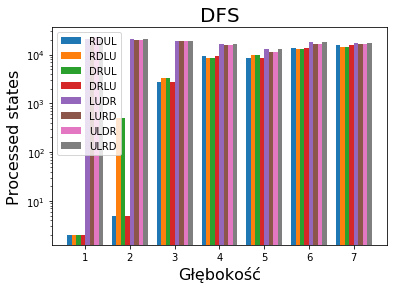

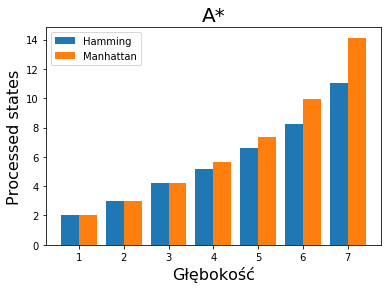

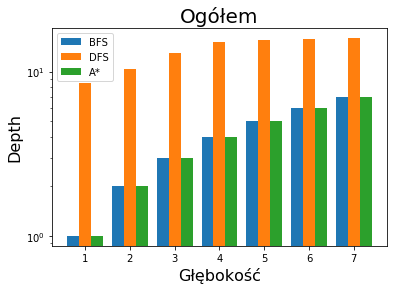

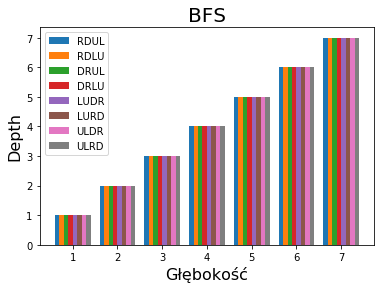

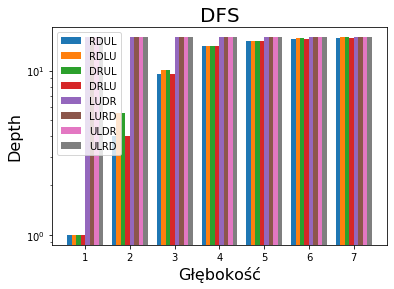

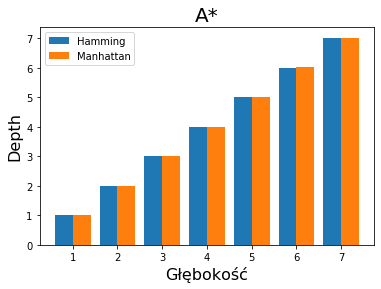

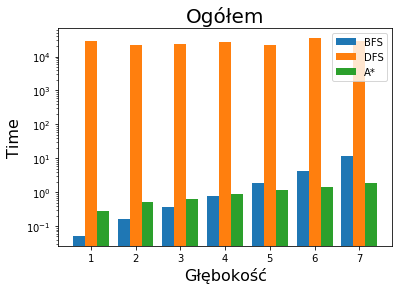

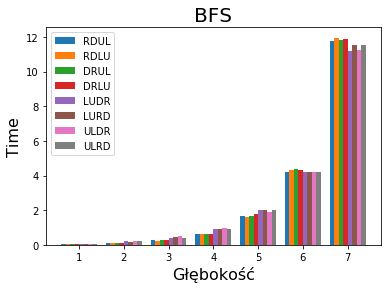

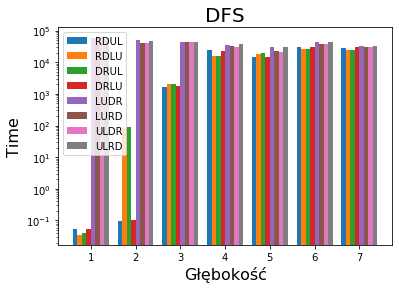

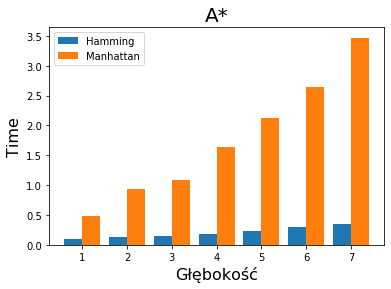

Done: Drawing plots


In [7]:
def barPlot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
	if colors is None:
		colors = plot.rcParams['axes.prop_cycle'].by_key()['color']
	n_bars = len(data)
	bar_width = total_width / n_bars
	bars = []
	for i, (name, values) in enumerate(data.items()):
		values = list(values.values())
		x_offset = (i - n_bars / 2) * bar_width + bar_width / 2
		for x, y in enumerate(values):
			bar = ax.bar((x + 1) + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])
		bars.append(bar[0])
	if legend:
		ax.legend(bars, data.keys())

for stat in stats:
	fig, ax = plot.subplots()
	plot.xticks(np.arange(1, 8, 1))
	plot.ylabel(stat, fontsize=16)	
	plot.xlabel("Głębokość", fontsize=16)
	globalStats[stat]["BFS"] = globalStats[stat].pop("bfs")
	globalStats[stat]["DFS"] = globalStats[stat].pop("dfs")
	globalStats[stat]["A*"] = globalStats[stat].pop("astr")
	barPlot(ax, globalStats[stat])
	ax.set_yscale('log')
	plot.title("Ogółem", fontsize=20)
	plot.show()
	for strategy in strategies:
		fig, ax = plot.subplots()
		plot.xticks(np.arange(1, 8, 1))
		plot.ylabel(stat, fontsize=16)
		plot.xlabel("Głębokość", fontsize=16) 
		if strategy == "bfs":
			barPlot(ax, bfsStats[stat])
			ax.set_yscale('linear')
			plot.title("BFS", fontsize=20)
		if strategy == "dfs":
			barPlot(ax, dfsStats[stat])
			ax.set_yscale('log')
			plot.title("DFS", fontsize=20)
		if strategy == "astr":
			astrStats[stat]["Hamming"] = astrStats[stat].pop("hamm")
			astrStats[stat]["Manhattan"] = astrStats[stat].pop("manh")
			barPlot(ax, astrStats[stat])
			ax.set_yscale('linear')
			plot.title("A*", fontsize=20)
		plot.show()
        
print("Done: Drawing plots")